In [1]:
"""
	minhhai messes around with the example
"""
%matplotlib notebook

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import numpy as np
import itertools

from adapt.refine import refine_scalar_field, smallest_length, average_length, reach_average_length

NUM_X 	= 250
NUM_Y 	= 250
NUM_COARSE_X = 20
NUM_COARSE_Y = 20

NOISE_LEVEL = 0.1

ITERATION 	= 15
MAX_POINTS = 4e+4	# Maximum number of points to take
ACCEPT_NOISE = 0.0	# seem not necessary
ACCEPT_RESOLUTION = 2e-3

In [2]:
def lg(x, xc, k=50.0):
	return 1.0/(1.0 + np.exp(-k*(x-xc)))
def f(x, y, x0=0.8, y0=0.09, k=50.0):
	xc = x0 / (y/y0 - 1) 
	return lg(x, xc, k=k)
def ff(v):
	return f(*v, x0=0.8, y0=0.09, k=50) - f(*v, x0=3, y0=0.09, k=25.0) + np.random.random()*NOISE_LEVEL

<IPython.core.display.Javascript object>


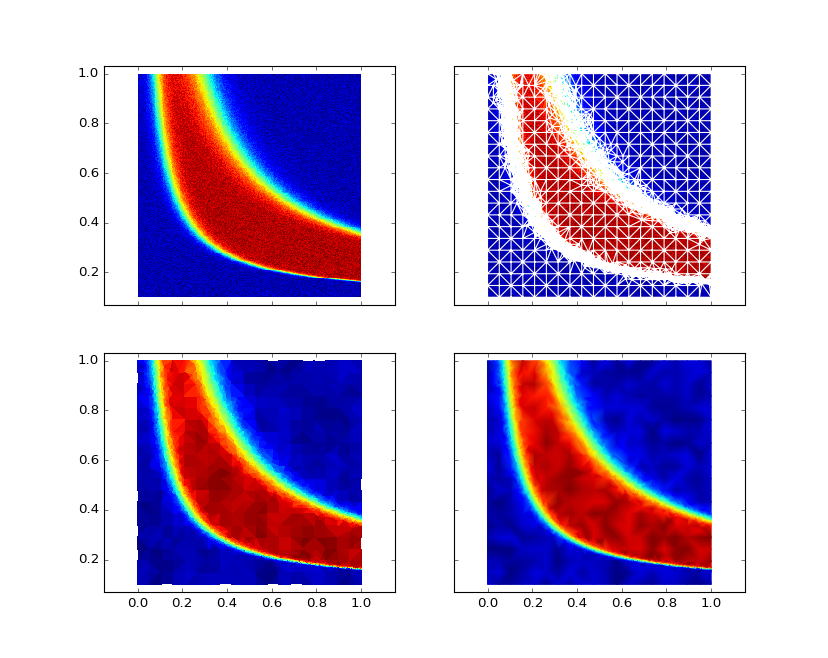

In [3]:
xs = np.linspace(0, 1, NUM_X)
ys = np.linspace(0.1, 1, NUM_Y)
xx, yy = np.meshgrid(xs, ys)

extent = (xs[0], xs[-1], ys[0], ys[-1])
aspect = (xs[-1]-xs[0])/(ys[-1]-ys[0])
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8), sharey=True, sharex=True)

coarse_xs = list(np.linspace(xs[0], xs[-1], NUM_COARSE_X))
coarse_ys = list(np.linspace(ys[0], ys[-1], NUM_COARSE_Y))
points    = [coarse_xs, coarse_ys]
points    = list(itertools.product(*points))

In [4]:
# original data with noise
values_orig = np.zeros((len(xx), len(yy)))
for i in range(len(xx)):
	for j in range(len(yy)):
		values_orig[i,j] = ff((xx[i,j], yy[i,j]))

# ax1 and ax2 be signal with noise
ax1.imshow(values_orig, origin='lower', extent=extent, aspect=aspect, interpolation='none')
ax2.imshow(values_orig, origin='lower', extent=extent, aspect=aspect, interpolation='none')

# Evaluate values at original mesh points
values = np.apply_along_axis(ff, 1, points)

In [5]:
# Find new points and update values
for i in range(ITERATION):
	new_points = refine_scalar_field(points, values, all_points=False,
								criterion="difference", threshold = "one_sigma",
								resolution=ACCEPT_RESOLUTION, noise_level=ACCEPT_NOISE)
	if new_points is None:
		print("No more points can be added.")
		break
	# Update points and values
	points = np.append(points, new_points, axis=0)
	new_values = np.apply_along_axis(ff, 1, new_points)
	values = np.append(values, new_values, axis=0)

	if len(points) > MAX_POINTS:
		print("Reach maximum number of points! Stop.")
		break

133 new points added.
167 new points added.
186 new points added.
266 new points added.
399 new points added.
546 new points added.
747 new points added.
802 new points added.
783 new points added.
760 new points added.
725 new points added.
667 new points added.
596 new points added.
517 new points added.
448 new points added.


In [6]:
print("Ended up with {} points in total.".format(len(points)))
smallest = smallest_length(points)
average = average_length(points)
print("Smallest element edge length: {}".format(smallest))
print("Average element edge length: {}".format(average))
print("Approximate savings with respect to square grid at smallest feature size: {}.".format(len(points)/((1.0/smallest)**2)))
print("Approximate savings with respect to square grid at average feature size: {}.".format(len(points)/((1.0/average)**2)))
print("Approximate savings with respect to square grid at original feature size: {}.".format(len(points)/(NUM_X*NUM_Y)))


Ended up with 8142 points in total.
Smallest element edge length: 0.0002765958891255961
Average element edge length: 0.006612429397864513
Approximate savings with respect to square grid at smallest feature size: 0.0006229060376445598.
Approximate savings with respect to square grid at average feature size: 0.35600261993487026.
Approximate savings with respect to square grid at original feature size: 0.130272.


In [7]:
mesh = Delaunay(points)
ax2.triplot(mesh.points[:,0], mesh.points[:,1], mesh.simplices.copy(), 'w-')
values = np.apply_along_axis(ff, 1, mesh.points) 
ax3.tripcolor(mesh.points[:,0], mesh.points[:,1], mesh.simplices.copy(), values)
ax4.tripcolor(mesh.points[:,0], mesh.points[:,1], mesh.simplices.copy(), values, shading='gouraud')
plt.show()